### Save Mr. Arnie!
---
Leaders at **Tenyks** have entrusted me with the mission to rescue Mr. Arnie from Skynet's nefarious plot. Skynet has dispatched an agent back in time to tamper with the labels in Mr. Arnie's training dataset, which could potentially compromise his friendly terminator identity.

My objective is to develop a model capable of identifying images of Mr. Arnie amidst a sea of enemy images. To achieve this, I will employ post-hoc concept-based analysis especifically **TCAV Model** and implement necessary fixes to enhance the model's performance. These improvements will ensure the model is prepared for further training and capable of distinguishing Mr. Arnie accurately.

This notebook talks about my approach and the results of my experiments.

### Necessary Imports!
---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import model as model
import tcav as tcav
import tcav_utils as utils
from tcav_utils import plot_results as utils_plot, set_seed
import os
import logging
import torch
import activations as generator_fn
import numpy as np
import random
import torch.nn.functional as F
import pickle
from cav import CAV

/DATA/charchit.sharma/miniconda3/envs/charchit_irt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


### Selection of Concepts for the TCAV Model!
---

while doing some inspection for the images of the Mr. Arnie I thought of going forward with the following concepts which are present in the images:

> "Skin" :  Since, Mr. Arnie is a human his skin is differnet from a skynet robot and so, this was the first concept that came to my mind and I thought it will give us a huge advantage as well since the background is also of the same texture.

> "Guns" : Since, Mr. Arnie is holding a gun in his hand it can also be a good concept.

> "sunglasses" : Mr. Arnie being a stylish guy is wearing a aviator sunglasses and the terminators have red scary eyes. 
---

### How to get these concepts?
---
To get these concepts I used google images website and search for these keywords,

> Skin texture
> Guns 
> Sunglasses 

Once the images are loaded we can use this command : In Google Chrome press Ctrl + Shift + j on Windows/Linux and Cmd + Optj on macOS, and a small window the javascript 'Console' will appear. There we can use this code : 

    urls=Array.from(document.querySelectorAll('.rg_i')).map(el=> el.hasAttribute('data-src')?el.getAttribute('data-src'):el.getAttribute('data-iurl'));
    window.open('data:text/csv;charset=utf-8,' + escape(urls.join('\n')));

this will generate a CSV file with all the URLs of the images. Then we can download then with the script present in the /utils folder. I have also attached the csv's which we can use to download these images.

---


### Let's visualize these concepts!

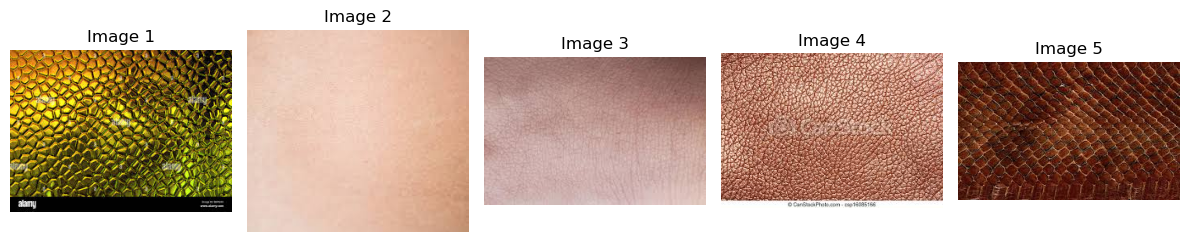

In [3]:
from tcav_utils import view_random_images
# these are some of the skin concepts we considered.
view_random_images('./source_dir/skin')

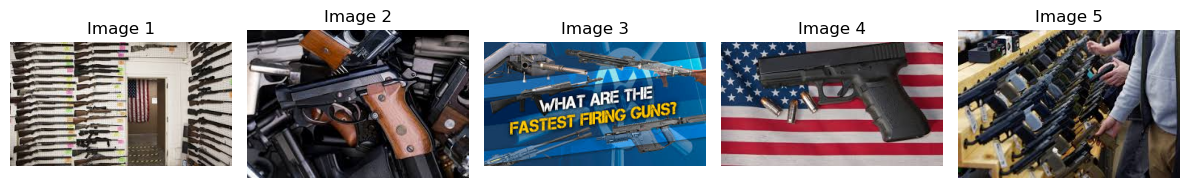

In [4]:
# these are some of the sunglasses and guns concepts!
view_random_images('./source_dir/guns')

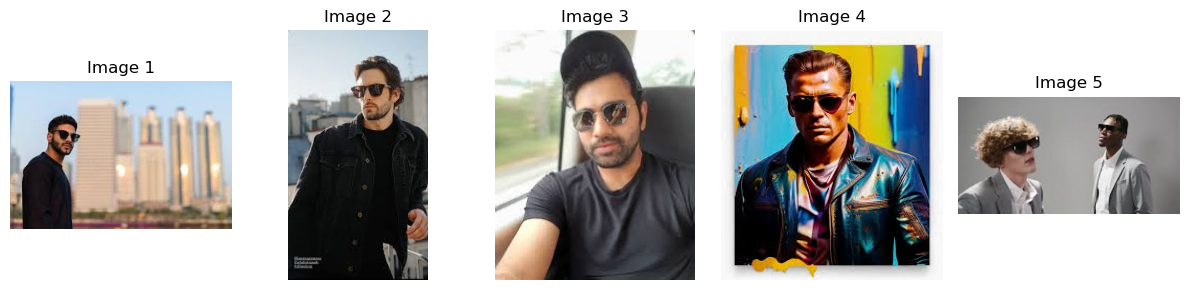

In [5]:
view_random_images('./source_dir/sunglasses_final')

### TCAV Implentation and Training
---
So, the general idea of TCAV is pretty simple!
TCAV scores for a given layer, a list of concepts and input example are computed using the dot product between prediction's layer
sensitivities for given input examples and Concept Activation Vectors (CAVs) in that same layer. 

CAVs are defined as vectors that are orthogonal to the classification boundary hyperplane that separate given concepts in a given layer from each other. How are they trained? : 

For a given layer, 
    1. Pass in a set of concept examples and a set of random images.
    2. Get activations for them
    3. CAVs are computed by training a classifier that uses these layer activation vectors.

Once you have these CAV's vector, you take your target Image(in our case Arnie image) and pass it through the model, which gives us the logits, and then you take the derivative of the the logits wrt CAV's vector which gives you the sensitivity SEN of each target image. Then you have the TCAV score (i.e., ratio of pictures that returns negative dot product wrt loss).

The implementation is heavily inspired by the official tensorflow repository (My whole code is in **Pytorch**)


### Let's sart by defining the directories where the activations and CAV's will be stored


In [6]:
working_dir = './test2'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
grads_dir = working_dir + '/grads/'
results_dir = working_dir + '/results/'
logs_dir = working_dir + '/logs/'
source_dir = "./source_dir/"


utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)
utils.make_dir_if_not_exists(grads_dir)
utils.make_dir_if_not_exists(results_dir)
utils.make_dir_if_not_exists(logs_dir)


In [7]:
# we define our models bottleneck layers
bottlenecks = ['layer1', 'layer2','layer3']

# target is our enemy class folder
target = 'Enemy'  

# concept is the concepts we select for the arnie dataset
concepts = ["skin", "sunglasses", "guns"]

# this is for test
random_counterpart = 'random500_0'


In [8]:
model_wrapper = model.ArnieWrapper()
act_generator = generator_fn.ImageActivationGenerator(model_wrapper, source_dir, activation_dir,custom=True,max_examples=1000)

In [9]:
# this is for index for each random folder, 
random_folder_idx=10 

# setting up seed for reproducibility
set_seed(10)

calculate_tcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   cav_hparams=None,
                   random_counterpart='random500_0',
                   cav_dir=cav_dir,
                   grads_dir=grads_dir,
                   num_random_exp=random_folder_idx, seed_val=10)


#### Let's run our TCAV Model!

In [10]:
results = calculate_tcav.run()

## Let's try the similarity search for the Arnie Images!
> Interestingly Section 4.1.1 in the TCAV Paper talks about how can we approach the task!
We can use CAVs to sort images with respect to their relation to the concept. This is useful for qualitative confirmation that the CAVs correctly reflect the concept of interest. As a CAV encodes the direction of a concept in the vector space of a bottleneck, vlC ∈ R m using the activations of the concept pictures, fl(xi) ∈ R m as described Section 3.2, we can compute cosine similarity between a set of pictures
of interest to the CAV to sort the pictures.

That's exactly we can do to search for Mr. Arnie!
- Take Skin CAV Vector at Layer L
- Take Enemy images activation vectors at Layer L
- Do the cosine similarity and sort the images!
- We have majority of the Arnie Images!


### Load the activations
- Remember they are activations we got after passing Enemy images which contains Mr. Arnie to the layer L of the model.

In [12]:
activations = torch.from_numpy(np.load('/DATA/charchit.sharma/final_submission/TCAV_functionality/test2/activations/acts_Enemy_arnie_model_layer3'))

In [13]:
len(activations)

1000

#### Load the CAV Vector for Skin
- Remember that the CAV vector should be of the same layer.

In [14]:
from cav import CAV
import pickle

fpth = './test2/cavs/skin-random500_1-arnie_model-layer3-logistic-1.0.pkl'
with open(fpth, 'rb') as pkl_file:
    save_dict = pickle.load(pkl_file)

cav = CAV(save_dict['concepts'], save_dict['bottleneck'],
            save_dict['hparams'], save_dict['saved_path'])
cav.accuracies = save_dict['accuracies']
cav.cavs = save_dict['cavs']


#### Checking the Cosine similarity between each activations of the Arnie Images and the CAV Vector!

In [15]:
import torch.nn.functional as F

# 2. Calculate cosine similarity for each image
# Reshape activations for cosine similarity calculation
activations = activations.view(1000, -1)
cav_data = torch.from_numpy(cav.cavs[0]).view(1,-1)
# Calculate cosine similarity
similarities = F.cosine_similarity(activations, cav_data, dim=1)

# 3. Sort images based on cosine similarity (ascending order, higher values are more similar)
sorted_indices = torch.argsort(similarities, descending=True)

# Now, sorted_indices contains the indices of the images sorted by cosine similarity
# print(sorted_indices)

In [17]:
filename_data = act_generator.get_examples_for_concept("Enemy")
filename_data_files = act_generator.data_filename
print(len(filename_data_files))

1020


In [21]:
filename_data_files[:10]

['./source_dir/Enemy/99b8c29d04d842d098789faaa73e7c94.jpg',
 './source_dir/Enemy/2971eea9bc2c41f0ae8b61459c890a98.jpg',
 './source_dir/Enemy/3edfc94a52cb4a9a873627b4a2cb4c61.jpg',
 './source_dir/Enemy/1555c66eba58494785f2210e669f4e58.jpg',
 './source_dir/Enemy/f573e1121d274d7ca602a722d305bec6.jpg',
 './source_dir/Enemy/be8acbf776924d068bda147e6c89f411.jpg',
 './source_dir/Enemy/308fdd79148441ecb8099854fc0f0664.jpg',
 './source_dir/Enemy/906fcb315fb4466c842308c1a2cb13d5.jpg',
 './source_dir/Enemy/d2f7b5867c814c1b9be0e9c4aac9ebe5.jpg',
 './source_dir/Enemy/095e7c83df52491abf426231b23edd5a.jpg']

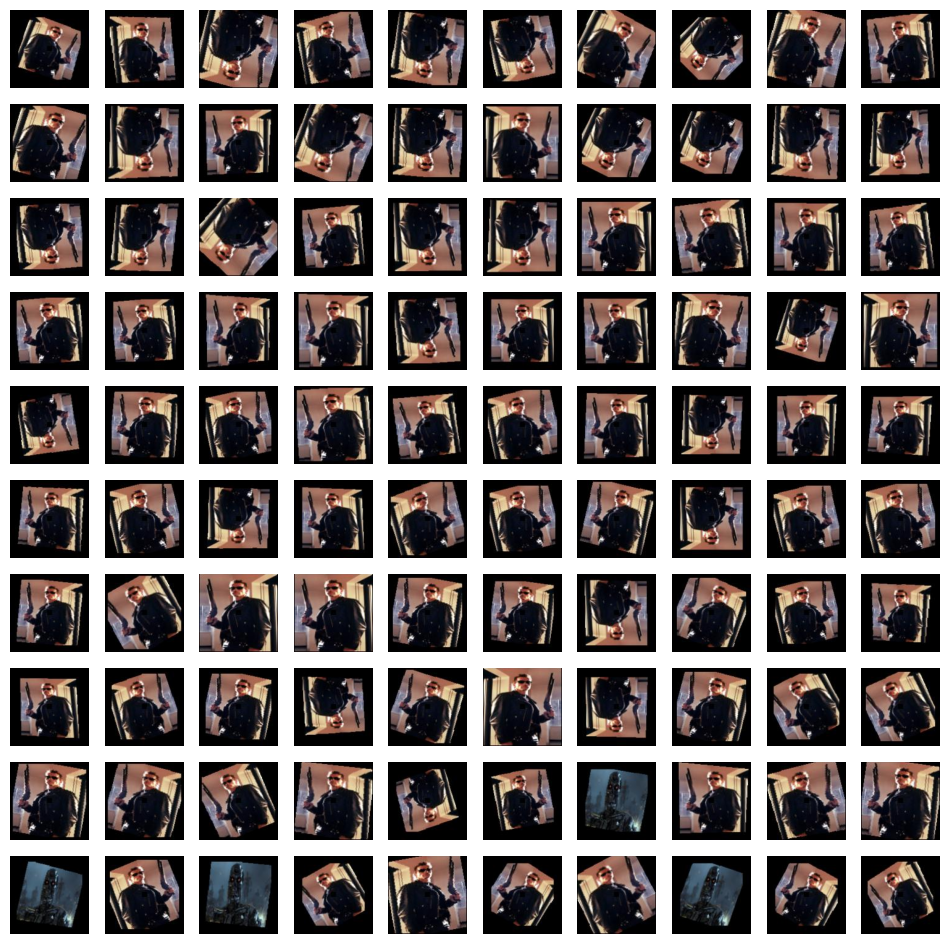

In [23]:
from tcav_utils import visualize_list

visualize_list(filename_data_files, sorted_indices,200)

## Additional Test with ResNet18 Model

In [15]:
working_dir = './test3'
activation_dir =  working_dir + '/activations/'
cav_dir = working_dir + '/cavs/'
grads_dir = working_dir + '/grads/'
results_dir = working_dir + '/results/'
logs_dir = working_dir + '/logs/'
source_dir = "./source_dir/"


utils.make_dir_if_not_exists(activation_dir)
utils.make_dir_if_not_exists(working_dir)
utils.make_dir_if_not_exists(cav_dir)
utils.make_dir_if_not_exists(grads_dir)
utils.make_dir_if_not_exists(results_dir)
utils.make_dir_if_not_exists(logs_dir)


model_wrapper = model.ResNet18Wrapper()
act_generator = generator_fn.ImageActivationGenerator(model_wrapper, source_dir, activation_dir,custom=False,max_examples=1000)


# this is for index for each random folder, 
random_folder_idx=10 

# setting up seed for reproducibility
set_seed(10)

calculate_tcav = tcav.TCAV(target,
                   concepts,
                   bottlenecks,
                   act_generator,
                   cav_hparams=None,
                   random_counterpart='random500_0',
                   cav_dir=cav_dir,
                   grads_dir=grads_dir,
                   num_random_exp=random_folder_idx, seed_val=10)

results = calculate_tcav.run()               

Class = Enemy
  Concept = skin
    Bottleneck = layer1. TCAV Score = 0.04 (+- 0.02), random was 0.43 (+- 0.19). p-val = 0.000 (significant)
    Bottleneck = layer2. TCAV Score = 0.13 (+- 0.03), random was 0.37 (+- 0.16). p-val = 0.000 (significant)
    Bottleneck = layer3. TCAV Score = 0.77 (+- 0.20), random was 0.62 (+- 0.30). p-val = 0.229 (not significant)
  Concept = sunglasses
    Bottleneck = layer1. TCAV Score = 0.29 (+- 0.16), random was 0.43 (+- 0.19). p-val = 0.113 (not significant)
    Bottleneck = layer2. TCAV Score = 0.12 (+- 0.06), random was 0.37 (+- 0.16). p-val = 0.000 (significant)
    Bottleneck = layer3. TCAV Score = 0.01 (+- 0.01), random was 0.62 (+- 0.30). p-val = 0.000 (significant)
  Concept = guns
    Bottleneck = layer1. TCAV Score = 0.65 (+- 0.13), random was 0.43 (+- 0.19). p-val = 0.008 (significant)
    Bottleneck = layer2. TCAV Score = 0.34 (+- 0.22), random was 0.37 (+- 0.16). p-val = 0.776 (not significant)
    Bottleneck = layer3. TCAV Score = 0.07 (+

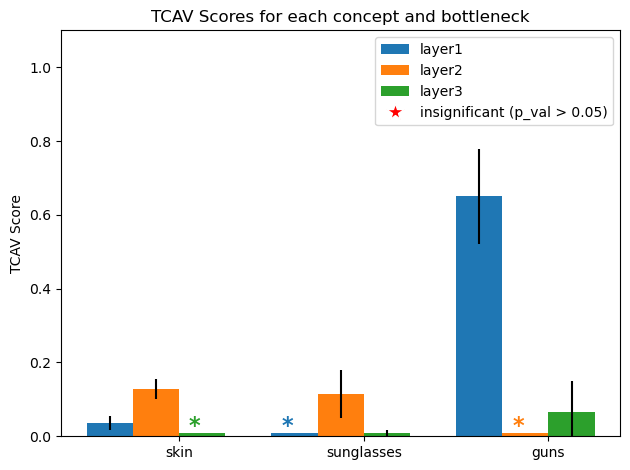

In [17]:
utils_plot(
    results, 
    num_random_exp=random_folder_idx,
    random_counterpart='random500_0',seed_val=10)

In [33]:
activations = torch.from_numpy(np.load('/DATA/charchit.sharma/final_submission/TCAV_functionality/test3/activations/acts_Enemy_resnet18_public_layer1'))
print(activations.shape)

fpth = '/DATA/charchit.sharma/final_submission/TCAV_functionality/test3/cavs/guns-random500_1-resnet18_public-layer1-logistic-1.0.pkl'
with open(fpth, 'rb') as pkl_file:
    save_dict = pickle.load(pkl_file)

cav = CAV(save_dict['concepts'], save_dict['bottleneck'],
            save_dict['hparams'], save_dict['saved_path'])
cav.accuracies = save_dict['accuracies']
cav.cavs = save_dict['cavs']


# 2. Calculate cosine similarity for each image
# Reshape activations for cosine similarity calculation
activations = activations.view(1000, -1)
cav_data = torch.from_numpy(cav.cavs[0]).view(1,-1)
# Calculate cosine similarity
similarities = F.cosine_similarity(activations, cav_data, dim=1)

# 3. Sort images based on cosine similarity (ascending order, higher values are more similar)
sorted_indices = torch.argsort(similarities, descending=True)

# Now, sorted_indices contains the indices of the images sorted by cosine similarity
# print(sorted_indices)

filename_data = act_generator.get_examples_for_concept("Enemy")
filename_data_files = act_generator.data_filename
print(len(filename_data_files))

torch.Size([1000, 64, 64, 64])
1020


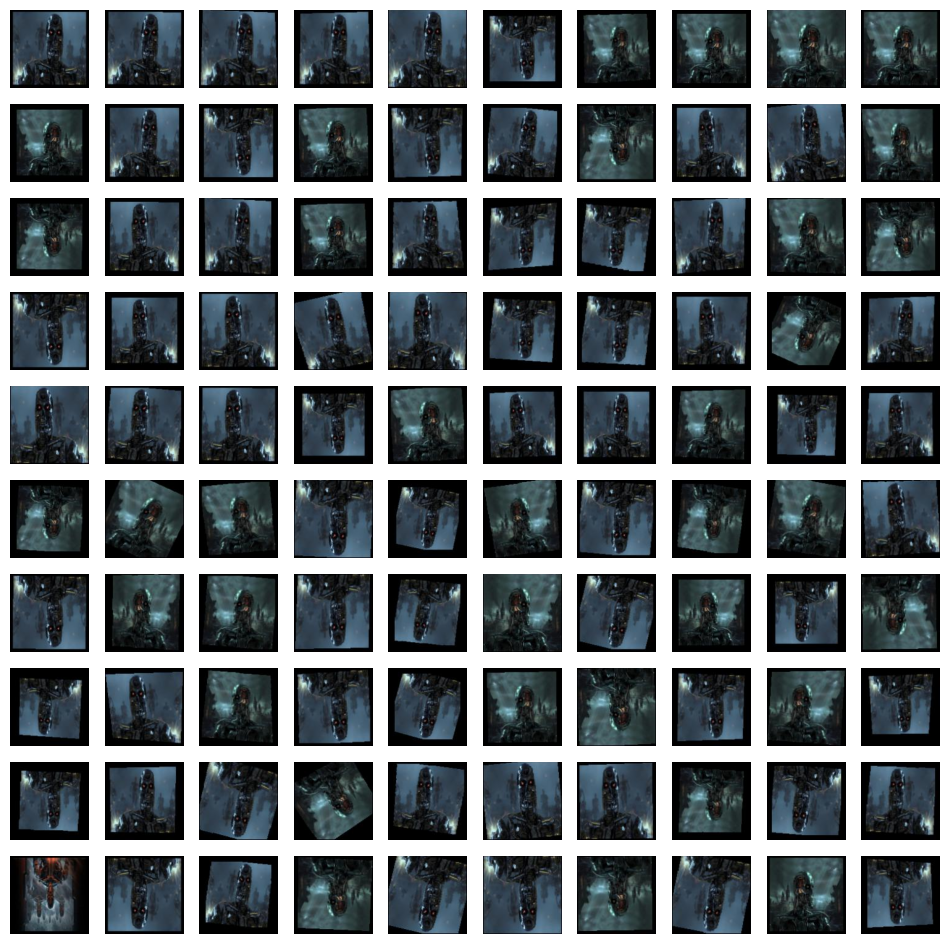

In [34]:
from tcav_utils import visualize_list

visualize_list(filename_data_files, sorted_indices,100)

In [22]:

visualize_list(filename_data_files, sorted_indices,100)

tensor([539, 941, 215, 418, 304, 602, 607, 839, 934, 427, 206, 542, 555, 510,
        254, 190, 702, 170, 749, 714])

In [36]:
def give_idx(filename_data_files, arr):

    """
    Args:
        -  torch arr which contains indices for the images to view.
        -  idx1: index to start from. 
    Returns:
        - None. Shows the images. 
    """

    # Specify the indices of the images you want to view (100 images)

    # helper function!
    # dict to get the idx to filename mapping. 
    dict_for_filname_act = {}
    need_to_change_idx = []
    main_pth = './source_dir/Enemy/'
    for idx, fname in enumerate(filename_data_files):
        img = fname.split('/')[-1]
        dict_for_filname_act[idx] = img


    index_to_view = arr.tolist()[:185]  # Change this to the desired range

    # Loop through the indices and display the images
    for i, index in enumerate(index_to_view):
        image_path = dict_for_filname_act.get(index)
        need_to_change_idx.append(image_path)
    
    return need_to_change_idx
        

In [1]:
idx_to_change = give_idx(filename_data_files, sorted_indices)

NameError: name 'give_idx' is not defined

In [39]:
idx_to_change[:180]

['b3f40b1a23ae45179b196e9dd82f1908.jpg',
 '6bd3b7adfe864889ab856eceee8dab7c.jpg',
 '480a512ec59f4ab8943f2e42092110e8.jpg',
 'adc5642180224347b45fa48d1c8798a4.jpg',
 '40a8d04fec1c492ab91c1b27bf8ea849.jpg',
 '8eb8f70517484fb88cd55d6e1d89248e.jpg',
 '4bab65b163654214a149ca0534cfaba6.jpg',
 '7f70fb092999491bb545111ef73fb49a.jpg',
 'cbcf76c6d7a046e0b77a9c6b72a3e978.jpg',
 '9958bf1d8d64423d9b555c838ecdda97.jpg',
 '7d71af4bc47c4a96b69e9fa72c4cf5df.jpg',
 '6dfd81c62a3c4875be7182c56c2b2ff4.jpg',
 '9db3c1f0090b435b8f6ce3211e5ebacd.jpg',
 '7c39995780b8416f9570a88d4b058c70.jpg',
 '7ddf845e69ac432bb77c78eda26b4d52.jpg',
 '3fa77c3dd66841acad35ce85f8b657be.jpg',
 '6d91f6b660ad470694b02f771d29fbcc.jpg',
 'cbdad1c8fa4e408884a63a408f7a4b82.jpg',
 '46d8e4a83f9541089b879e39081965cd.jpg',
 'd7807a5ecee44aa3917f7c6c4ef561f3.jpg',
 '583292e25b474d058fc45489179b593c.jpg',
 '860439d8bd0d4d7eb16adf0f7115e0ef.jpg',
 'fc2d74592aa6491eb4facc49881c0ed8.jpg',
 '941efc0d7c404774899aaa3ef56986cf.jpg',
 '36cc5d3ee6b345

In [30]:
'bf5f1359f8534215ba6413288f38acba.jpg' in idx_to_change

False

In [40]:
len(activations)

1000